In [19]:
#%pip install rasterstats
%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main
import geopandas as gpd
import rasterio
from rasterio.merge import merge
from rasterstats import zonal_stats
from rasterio.mask import mask
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

  Cloning https://github.com/Nadiesenali/snowdroughtindex-main to c:\users\walimunige.rupasingh\appdata\local\temp\pip-req-build-c59omgwd
  Resolved https://github.com/Nadiesenali/snowdroughtindex-main to commit ad39afcc4fde17318cc1b91898e53650bb455327
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/294.9 kB ? eta -:--:--
     ---------------                        122.9/294.9 kB 7.0 MB/s eta 0:00:01
     -----------------------                184.3/294.9 kB 3.7 MB/s eta 0:00:01
     -------------------------------        245.8/294.9 kB 2.2 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.8 MB/s eta 0:00:00
  Created wheel for snowdroughtindex: filename=snowdroughtindex-0.1.0-py3-none-any.whl size=72979 sha256=2bdc4c2cb59f1dcd5dbfb9ca7c5c066cfd90817bb14aef1dbea8d3b704f158ff
  Stored in directory: C:\Users\walimunige.rupasingh\AppData\Local\Temp\pip-ephem-

  Running command git clone --filter=blob:none --quiet https://github.com/Nadiesenali/snowdroughtindex-main 'C:\Users\walimunige.rupasingh\AppData\Local\Temp\pip-req-build-c59omgwd'


In [22]:
# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation
from snowdroughtindex.utils import visualization, io

In [45]:
shapefile_path = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\Elevation\Bow.shp"
output_data = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\elevation\\"
output_plots = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\\"
tif_files = glob.glob(r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\Elevation\*.tif")


In [40]:
# 1. Load Shapefile ===
gdf = data_preparation.load_basin_data(shapefile_path)

In [41]:
# 2. Merge the TIFs ===
src_files_to_mosaic = [rasterio.open(fp) for fp in tif_files]
mosaic, out_transform = merge(src_files_to_mosaic)

In [42]:
# 3. Write the Merged Raster to Disk ===
mosaic_meta = src_files_to_mosaic[0].meta.copy()
mosaic_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform
})

merged_tif_path = output_data+"merged_dem.tif"
with rasterio.open(merged_tif_path, "w", **mosaic_meta) as dest:
    dest.write(mosaic)

In [46]:
# 4. Compute Zonal Statistics ===
stats = zonal_stats(
    shapefile_path,
    merged_tif_path,
    stats=["min", "max", "mean", "std", "median", "count"],
    nodata=None,
    geojson_out=True
)

c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [47]:
# 5. Create GeoDataFrame with Stats ===
stats_gdf = gpd.GeoDataFrame.from_features(stats)

In [50]:
# 6. Save to New Shapefile or CSV ===
output_shapefile_path = os.path.join(output_data, "Bow_elevation_with_stats.shp")
output_dir = os.path.dirname(output_shapefile_path)
output_csv_path = os.path.join(output_dir, "Bow_stats.csv")

# save the GeoDataFrame to a shapefile
stats_gdf.to_file(output_shapefile_path)  # Save as shapefile
stats_gdf.drop(columns="geometry").to_csv(output_csv_path, index=False)  # Also save as CSV

print("✅ Elevation statistics extracted and saved.")

✅ Elevation statistics extracted and saved.


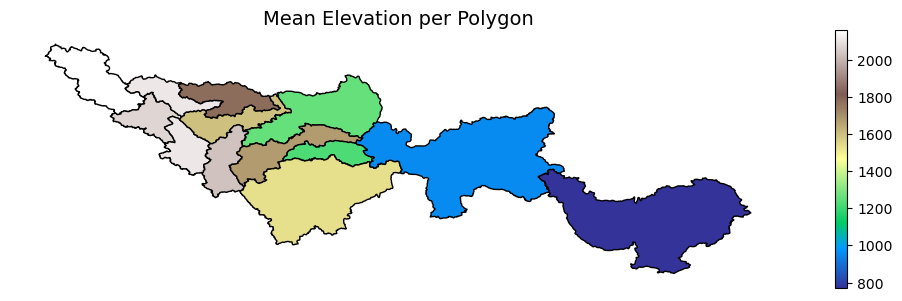

In [53]:
# Load shapefile with elevation stats
gdf = gpd.read_file(output_data+"Bow_elevation_with_stats.shp")  # or your output file

# Plot mean elevation
fig, ax = plt.subplots(figsize=(10, 3))
gdf.plot(column='mean', cmap='terrain', legend=True, edgecolor='black', ax=ax)

ax.set_title("Mean Elevation per Polygon", fontsize=14)
ax.axis('off')
plt.tight_layout()
# Save the plot
plt.savefig(os.path.join(output_plots, "mean_elevation_plot.png"), dpi=300)
plt.show()

In [54]:
# Clip the merged DEM using the geometry from the shapefile
with rasterio.open(merged_tif_path) as src:
	# Use all geometries from the GeoDataFrame
	shapes = [feature["geometry"] for feature in stats]
	clipped_dem, clipped_transform = mask(src, shapes=shapes, crop=True)

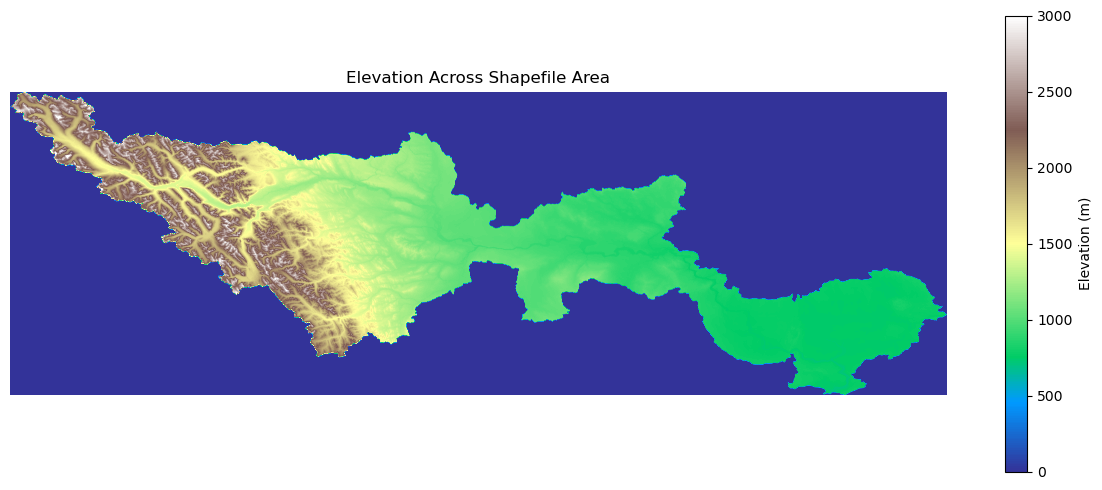

In [56]:
# Mask nodata using mosaic_meta or assume 0 is nodata if not set
nodata_value = mosaic_meta.get("nodata", 0)
clipped_data = np.where(clipped_dem[0] == nodata_value, np.nan, clipped_dem[0])

# Plot
plt.figure(figsize=(12, 5))
plt.imshow(clipped_data, cmap='terrain', vmin= 0, vmax=3000)  # Adjust vmin and vmax as needed
plt.colorbar(label="Elevation (m)")
plt.title("Elevation Across Shapefile Area")
plt.axis('off')
plt.tight_layout()
# Save the current figure as a PNG file in the output_path directory
plt.savefig(os.path.join(output_plots, 'clipped_elevation_map.png'), dpi=300, bbox_inches='tight')
plt.show()

In [58]:
# Example: Split polygons into elevation classes and save separate shapefiles

# Define elevation bins (adjust as needed)
elevation_bins = [0, 500, 1000, 1500, 2000,2500, 3000]
elevation_labels = [f"{elevation_bins[i]}_{elevation_bins[i+1]}m" for i in range(len(elevation_bins)-1)]

# Ensure 'mean' column exists in stats_gdf
if 'mean' in stats_gdf.columns:
    stats_gdf['elev_class'] = pd.cut(stats_gdf['mean'], bins=elevation_bins, labels=elevation_labels, include_lowest=True)
    # Convert to string for shapefile output
    stats_gdf['elev_class'] = stats_gdf['elev_class'].astype(str)
    for label in elevation_labels:
        subset = stats_gdf[stats_gdf['elev_class'] == str(label)]
        if not subset.empty:
            out_path = os.path.join(output_dir, f"Bow_elevation_{label}.shp")
            subset.to_file(output_data)
            print(f"Saved: {output_data}")
else:
    print("Column 'mean' not found in stats_gdf.")

Saved: C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\elevation\\
Saved: C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\elevation\\
Saved: C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\elevation\\
Saved: C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\elevation\\


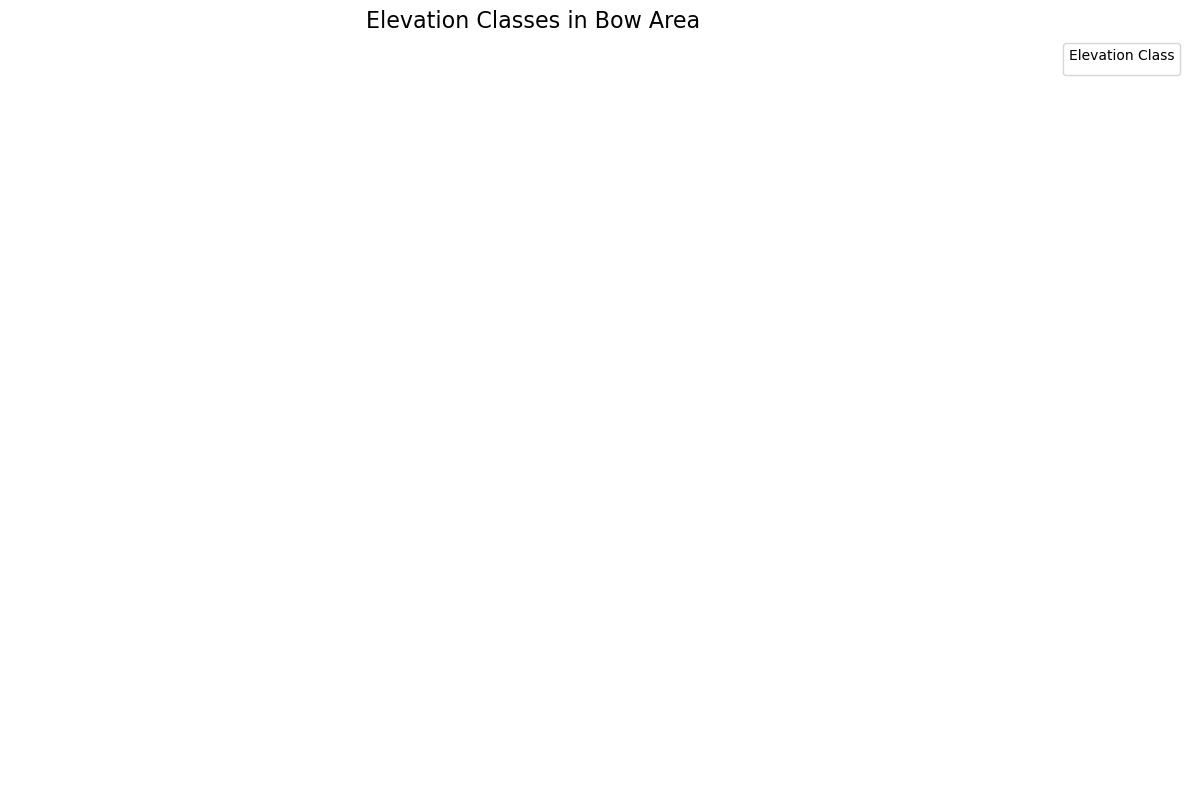

In [60]:
# Plot all elevation class shapefiles in one plot

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.terrain(np.linspace(0, 1, len(elevation_labels)))
legend_handles = []

for i, label in enumerate(elevation_labels):
    shp_path = os.path.join(output_dir, f"Bow_elevation_{label}.shp")
    if os.path.exists(shp_path):
        class_gdf = gpd.read_file(shp_path)
        class_gdf.plot(ax=ax, color=colors[i], label=label, edgecolor='black', linewidth=0.5)
        legend_handles.append(mpatches.Patch(color=colors[i], label=label))

ax.set_title("Elevation Classes in Bow Area", fontsize=16)
ax.axis('off')
ax.legend(handles=legend_handles,title="Elevation Class", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

